<p>This file shows the effectiveness of simulating data when starting the model.</p>

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy import signal
from scipy.integrate import simps
from scipy.fftpack import fft
from scipy.signal import resample
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook as tqdm

In [38]:
dir = "C:/Users/我的电脑/desktop/Harvard/WearableDevicesAndComputerVision/project/data3/"

In [39]:
files = os.listdir(dir+'FreeThrows_7_31')
md = pd.read_csv(dir+'motion_data.csv')

In [40]:
def trim_data(w,a):
    w2 = w['wx']**2 + w['wy']**2 + w['wz']**2
    a2 = a['ax']**2 + a['ay']**2 + a['az']**2
    center_index = w2.idxmax()
    empty_frame = (pd.DataFrame([],columns=w.columns),pd.DataFrame([],columns=a.columns))
    if w2.max()>2250000 and center_index-5>=0 and center_index+5<len(w2):
        start_index = center_index
        stop_index = center_index
        while (sum(list(w2[start_index:start_index+5]))/5 >50 or (w['time'][center_index]-w['time'][start_index])<200)\
        and start_index>1:
            start_index -= 1
        while sum(list(w2[stop_index-5:stop_index]))/5 >50 and stop_index<len(w2)-1:
            stop_index += 1
        start_time = w['time'][start_index]
        stop_time = w['time'][stop_index]
        w = w[w['time']>=start_time]
        w = w[w['time']<=stop_time]
        a = a[a['time']>=start_time]
        a = a[a['time']<=stop_time]
        w = w.reset_index()
        a = a.reset_index()
        return (w,a)
    else:
        return empty_frame

def get_v(w, a):
    g = np.sqrt(a['ax'][0]**2+a['ay'][0]**2+a['az'][0]**2)
    v = np.array([0, 0, 0])
    phi = np.arctan(a['ay'][0]/a['ax'][0])
    theta = np.arctan(np.sqrt(a['ax'][0]**2+a['ay'][0]**2)/a['az'][0])
    x = [1, 0, 0]
    y = [0, 1, 0]
    z = [0, 0, 1]
    Ry = [[np.cos(theta),0,-np.sin(theta)], [0,1,0], [np.sin(theta),1,np.cos(theta)]]
    Rz = [[np.cos(phi),-np.sin(phi),0], [np.sin(phi),np.cos(phi),0], [0,0,1]]
    xp = np.matmul(Rz,np.matmul(Ry,x))
    yp = np.matmul(Rz,np.matmul(Ry,y))
    zp = np.matmul(Rz,np.matmul(Ry,z))
    
    for n in range(len(w)-1):
        dt = (w['time'][n+1]-w['time'][n])/1000
        phi = np.arctan(a['ay'][0]/a['ax'][0])
        theta = np.arctan(np.sqrt(a['ax'][0]**2+a['ay'][0]**2)/a['az'][0])
        G = np.matmul(Rz,np.matmul(Ry,z))*g/1000*9.8
        v = v + (a['ax'][n]*xp+a['ay'][n]*yp+a['az'][n]*zp+G)*9.8/1000*dt
        wv = np.array([w['wx'][n], w['wy'][n], w['wz'][n]])*np.pi/180
        xn = xp + dt*np.cross(wv,xp)
        yn = yp + dt*np.cross(wv,yp)
        zn = zp + dt*np.cross(wv,zp)
        xp = xn/np.sqrt(np.dot(xn,xn))
        yp = yn/np.sqrt(np.dot(yn,yn))
        zp = zn/np.sqrt(np.dot(zn,zn))
    return v

In [41]:
files = os.listdir(dir+'FreeThrows_7_31')
md = pd.read_csv(dir+'motion_data.csv')
md_made = md[md['make']==1]
made_files = md_made['file_name'].to_string()

df = pd.DataFrame([], columns=['ay_int', 'ay_mean', 'w_int', 'wxf', 'vx', 'vy', 'make'])

for file in tqdm(files):
    if 'w' in file:
        a = pd.read_csv(dir+'FreeThrows_7_31/'+file.split('w.')[0]+'a.csv')
        w = pd.read_csv(dir+'FreeThrows_7_31/'+file)
        w, a = trim_data(w, a)
        if len(w)>10:
            ay_int = simps(a['ay'],a['time'])
            ay_mean = a['ay'].mean()
            w_int = simps(np.sqrt(w['wx']**2+w['wy']**2+w['wz']**2),w['time'])
            v = get_v(w,a)
            vx = v[0]
            vy = v[1]
            N = len(w['time'])
            T = (w['time'][N-1]-w['time'][0])/N/1000
            t = np.linspace(0.0, N*T, N)
            f = np.linspace(0.0, 1.0/2/T, N//2)
            uniform_wx= resample(w['wx'], N, w['time'])
            fft_wx = fft(uniform_wx[0])
            wxfs = 2/N*np.abs(fft_wx[0:N//2])
            wxf = f[np.where(wxfs==wxfs.max())[0][0]] 
            if file.split('w')[0] in made_files:
                make = 1
            else:
                make = 0
            df.loc[len(df)] = [ay_int, ay_mean, w_int, wxf, vx, vy, make]

def get_score(n_data_points):
    global df
    small_df = pd.DataFrame([], columns=['ay_int', 'ay_mean', 'w_int', 'wxf', 'vx', 'vy', 'make'])
    while len(small_df)<n_data_points:
        file = np.random.choice(files)
        file = file.split('.')[0][:-1]+'w.csv'
        a = pd.read_csv(dir+'FreeThrows_7_31/'+file.split('w.')[0]+'a.csv')
        w = pd.read_csv(dir+'FreeThrows_7_31/'+file)
        w, a = trim_data(w, a)
        if len(w)>10:
            ay_int = simps(a['ay'],a['time'])
            ay_mean = a['ay'].mean()
            w_int = simps(np.sqrt(w['wx']**2+w['wy']**2+w['wz']**2),w['time'])
            v = get_v(w,a)
            vx = v[0]
            vy = v[1]
            N = len(w['time'])
            T = (w['time'][N-1]-w['time'][0])/N/1000
            t = np.linspace(0.0, N*T, N)
            f = np.linspace(0.0, 1.0/2/T, N//2)
            uniform_wx= resample(w['wx'], N, w['time'])
            fft_wx = fft(uniform_wx[0])
            wxfs = 2/N*np.abs(fft_wx[0:N//2])
            wxf = f[np.where(wxfs==wxfs.max())[0][0]] 
            if file.split('w')[0] in made_files:
                make = 1
            else:
                make = 0
            small_df.loc[len(small_df)] = [ay_int, ay_mean, w_int, wxf, vx, vy, make]
    only_data = small_df.drop(['make'], axis=1)
    while len(small_df)<70:
        mean = only_data.mean()
        std = only_data.std()
        new = np.random.normal(mean,std)
        if abs(new[4]-mean[4])<std[4] and abs(new[5]-mean[5])<std[5]:
            small_df.loc[len(df)] = list(new)+[1]
        else:
            small_df.loc[len(small_df)] = list(new)+[0]
    X = small_df.drop('make', axis=1)
    y = small_df['make']
    log_reg = LogisticRegression(solver='lbfgs')
    log_reg.fit(X, y)
    chosen_idx = np.random.choice(len(df), replace=False, size=int(len(df)*0.3))
    df_test = df.iloc[chosen_idx]
    y_test = df_test['make']
    X_test = df_test.drop(['make'],axis=1)
    score = log_reg.score(X_test, y_test)
    return score

In [42]:
n_points = []
accuracy = []
for n in tqdm(range(3,70)):
    trial_accuracy = 0
    for m in range(10):
        trial_accuracy += get_score(n)/10
    n_points.append(n)
    accuracy.append(trial_accuracy)
        
    

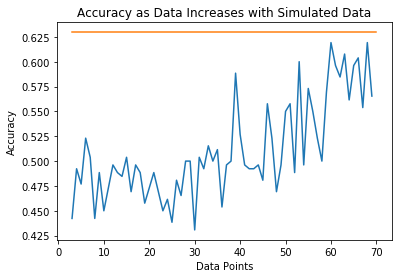

In [43]:
plt.plot(n_points,accuracy)
plt.plot([3,70], [0.6296296296296297,0.6296296296296297])
plt.title('Accuracy as Data Increases with Simulated Data')
plt.xlabel('Data Points')
plt.ylabel('Accuracy')
plt.show()

In [44]:
def get_score_without_sim(n_data_points):
    global df
    small_df = pd.DataFrame([], columns=['ay_int', 'ay_mean', 'w_int', 'wxf', 'vx', 'vy', 'make'])
    while len(small_df)<n_data_points or small_df['make'].sum()==0 or \
    small_df['make'].sum()==len(small_df):
        file = np.random.choice(files)
        file = file.split('.')[0][:-1]+'w.csv'
        a = pd.read_csv(dir+'FreeThrows_7_31/'+file.split('w.')[0]+'a.csv')
        w = pd.read_csv(dir+'FreeThrows_7_31/'+file)
        w, a = trim_data(w, a)
        if len(w)>10:
            ay_int = simps(a['ay'],a['time'])
            ay_mean = a['ay'].mean()
            w_int = simps(np.sqrt(w['wx']**2+w['wy']**2+w['wz']**2),w['time'])
            v = get_v(w,a)
            vx = v[0]
            vy = v[1]
            N = len(w['time'])
            T = (w['time'][N-1]-w['time'][0])/N/1000
            t = np.linspace(0.0, N*T, N)
            f = np.linspace(0.0, 1.0/2/T, N//2)
            uniform_wx= resample(w['wx'], N, w['time'])
            fft_wx = fft(uniform_wx[0])
            wxfs = 2/N*np.abs(fft_wx[0:N//2])
            wxf = f[np.where(wxfs==wxfs.max())[0][0]] 
            if file.split('w')[0] in made_files:
                make = 1
            else:
                make = 0
            small_df.loc[len(small_df)] = [ay_int, ay_mean, w_int, wxf, vx, vy, make]
            if len(small_df)>n_data_points:
                small_df.drop(small_df.index[0])
    X = small_df.drop('make', axis=1)
    y = small_df['make']
    log_reg = LogisticRegression(solver='lbfgs')
    log_reg.fit(X, y)
    chosen_idx = np.random.choice(len(df), replace=False, size=int(len(df)*0.3))
    df_test = df.iloc[chosen_idx]
    y_test = df_test['make']
    X_test = df_test.drop(['make'],axis=1)
    score = log_reg.score(X_test, y_test)
    return score

In [45]:
n_points_without = []
accuracy_without = []
for n in tqdm(range(3,70)):
    trial_accuracy = 0
    for m in range(10):
        trial_accuracy += get_score_without_sim(n)/10
    n_points_without.append(n)
    accuracy_without.append(trial_accuracy) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

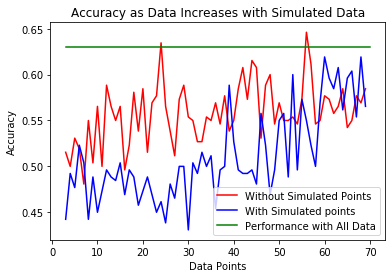

In [46]:
plt.plot(n_points_without, accuracy_without, 'r', label='Without Simulated Points')
plt.plot(n_points, accuracy, 'b', label='With Simulated points')
plt.plot([3,70], [0.6296296296296297,0.6296296296296297], 'g', label='Performance with All Data')
plt.legend(('Without Simulated Points', 'With Simulated points',\
           'Performance with All Data'))
plt.title('Accuracy as Data Increases with Simulated Data')
plt.xlabel('Data Points')
plt.ylabel('Accuracy')
plt.show()